# Efficient Frontier - Running the Optimizer

In order to plot the frontier for portfolios with more than 2 assets, we need to find the weights of the portfolio on the efficient frontier.

We start by creating the same sort of function that we already created for the 2 asset case:

```python

def plot_ef(n_points, er, cov):
    """
    Plots the multi-asset efficient frontier
    """
    weights = ???? # we need to implement: optimal_weights(n_points, er, cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style='.-')
```

In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import edhec_risk_kit_108 as erk

ind = erk.get_ind_returns()
er = erk.annualize_rets(ind["1996":"2000"], 12)
cov = ind["1996":"2000"].cov()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In order to find the optimal weights, we need a function that will minimize the volatility for a given level of return.


```python
from scipy.optimize import minimize

def minimize_vol(target_return, er, cov):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return - erk.portfolio_return(weights,er)
    }
    weights = minimize(erk.portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x
```

Let's use this to recreate the result we got from frontier for the 2-Asset optimization between "Games" and "Fin". Let's plot that efficient frontier as we did last time:

<Axes: xlabel='Volatility'>

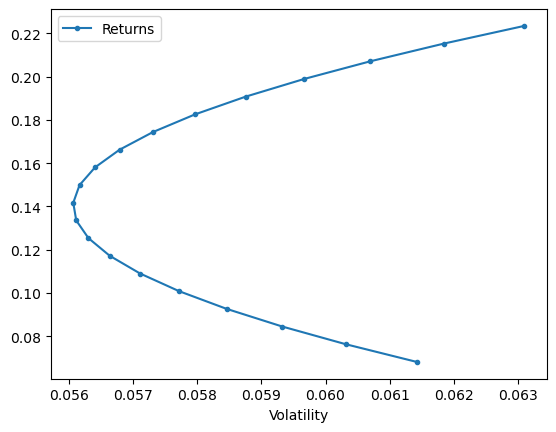

In [9]:
l = ["Games", "Fin"]
erk.plot_ef2(20, er[l], cov.loc[l,l])

The Efficient Frontier for the protfolio that has a target return of 0.15 is approx 0.056, so let's see if our optimizer is able to locate it.

In [16]:
weights_15 = erk.minimize_vol(0.15, er[l], cov.loc[l,l])
vol_15 = erk.portfolio_vol(weights_15, cov.loc[l,l])
vol_15

0.05616366940670658

Now that we can find the weights to minimize the vol given a target return, we can plot the efficient frontier by dividing up the range from the highest to the lowest possible return into a grid, and finding the portfolio that targets the minimum volatility given a particular targeted rate of return.

```python
def optimal_weights(n_points, er, cov):
    """
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

def plot_ef(n_points, er, cov):
    """
    Plots the multi-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov) # not yet implemented!
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style='.-')
```


<Axes: xlabel='Volatility'>

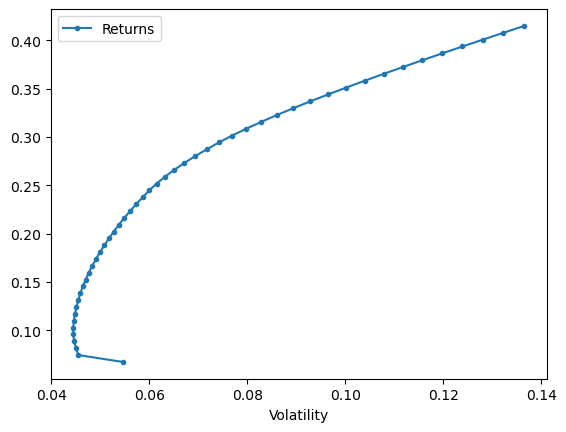

In [29]:
l = ["Smoke", "Fin", "Games", "Coal", "Meals"]
erk.plot_ef(50, er[l], cov.loc[l,l])

# Finding the Max Sharpe Ratio Portfolio

We've already seen that given a set of expected returns and a covariance matrix, we can plot the efficient frontier. We'll extend the code to locate the point on the efficient frontier that we are most interested in, which is the tangent portfolio or the Max Sharpe Ratio portfolio.

We already know how to identify points on the curve if we are given a target rate of return. Instead of minimizing the vol based on a target return, we want to find that one point on the curve that maximizes the Sharpe Ratio, given the risk free rate.

```python
def msr(riskfree_rate, er, cov):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol
    
    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x
```

(0, 0.13653194556346115)

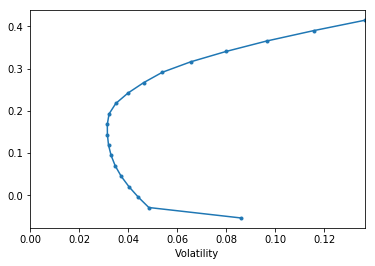

In [2]:
ax = erk.plot_ef(20, er, cov)
ax.set_xlim(left = 0)

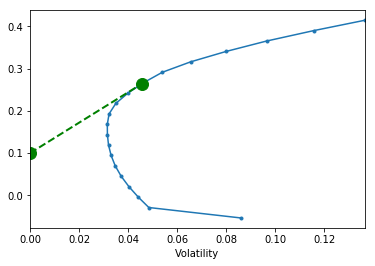

In [3]:
# plot EF
ax = erk.plot_ef(20, er, cov)
ax.set_xlim(left = 0)
# get MSR
rf = 0.1
w_msr = erk.msr(rf, er, cov)
r_msr = erk.portfolio_return(w_msr, er)
vol_msr = erk.portfolio_vol(w_msr, cov)
# add CML
cml_x = [0, vol_msr]
cml_y = [rf, r_msr]
ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)

In [4]:
r_msr, vol_msr

(0.2647394820740856, 0.0457197320872661)

Putting it all together by adding the CML to the `plot_ef` code.

```python
    if show_cml:
        ax.set_xlim(left = 0)
        # get MSR
        w_msr = msr(riskfree_rate, er, cov)
        r_msr = portfolio_return(w_msr, er)
        vol_msr = portfolio_vol(w_msr, cov)
        # add CML
        cml_x = [0, vol_msr]
        cml_y = [riskfree_rate, r_msr]
        ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)
```


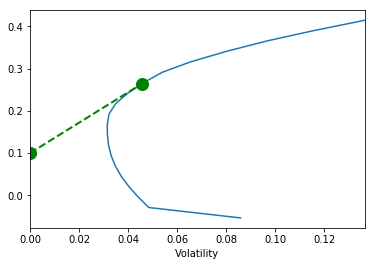

In [6]:
erk.plot_ef(20, er, cov, style='-', show_cml=True, riskfree_rate=0.1)